In [1]:
# Import necessary libraries
import cv2
import numpy as np
import os
import mediapipe as mp
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import random
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd

In [2]:
def normalize_keypoints(sequence):
    # Reshape to (frames, 42 landmarks, 3 coords)
    seq = sequence.reshape(sequence.shape[0], 42, 3)
    normalized = []

    for frame in seq:
        # 1. Compute wrist midpoint
        wrist_left  = frame[0]      # left-hand wrist
        wrist_right = frame[21]     # right-hand wrist
        origin = (wrist_left + wrist_right) / 2.0

        # 2. Centre all keypoints around that midpoint
        centred = frame - origin

        # 3. Flatten back to length-126 vector
        normalized.append(centred.flatten())

    return np.array(normalized)

In [3]:
# Define paths and actions
DATA_PATH = os.path.join('/Users/robayedashraf/Downloads/Dataset/data')

# Actions to detect
actions = np.array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
                    'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
                    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9','10',
                    'SPACE', 'BACKSPACE','BACKGROUND'])

# Number of sequences and sequence length
no_sequences = 80
sequence_length = 30

# Label mapping
label_map = {label: num for num, label in enumerate(actions)}

In [4]:
sequences, labels = [], []
for action in actions:
    for sequence_num in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence_num), f"{frame_num}.npy"))
            # Extract only hand keypoints

            res = res[-(21*3*2):]  # Assuming hand keypoints are at the end
            window.append(res)
        window = np.array(window)

        # Normalize keypoints
        window_normalized = normalize_keypoints(window)
        sequences.append(window_normalized)
        labels.append(label_map[action])


In [5]:
sequences = np.array(sequences)
labels = np.array(labels)
sequences = sequences.reshape(sequences.shape[0], -1) 

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    sequences, labels, test_size=0.3, random_state=42, stratify=labels
)

In [7]:
print(f"Training data shape: {X_train.shape}, Labels shape: {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, Labels shape: {y_test.shape}")

Training data shape: (2240, 3780), Labels shape: (2240,)
Testing data shape: (960, 3780), Labels shape: (960,)


In [8]:
num_classes = len(actions)

model = Sequential([
    Dense(1024, activation='relu', input_shape=(X_train.shape[1],)),
    # BatchNormalization(),
    Dropout(0.3),

    Dense(512, activation='relu'),
    # BatchNormalization(),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])


optimizer = Adam(learning_rate=1e-4)
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1024)           │     3,871,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 40)             │        20,520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,417,064 (16.85 MB)

 Trainable params: 4,417,064 (16.85 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = model.fit(
    X_train, y_train,
    epochs=80,
    batch_size=32,
    validation_data=(X_test, y_test)
)

# Evaluate the model on test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)

Epoch 1/80
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.1597 - loss: 3.3548 - val_accuracy: 0.4906 - val_loss: 2.3007
Epoch 2/80
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4295 - loss: 2.2353 - val_accuracy: 0.6635 - val_loss: 1.4757
Epoch 3/80
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5826 - loss: 1.5849 - val_accuracy: 0.7417 - val_loss: 1.0868
Epoch 4/80
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6753 - loss: 1.2080 - val_accuracy: 0.7552 - val_loss: 0.8878
Epoch 5/80
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6923 - loss: 1.0248 - val_accuracy: 0.8125 - val_loss: 0.7516
Epoch 6/80
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7571 - loss: 0.8675 - val_accuracy: 0.8625 - val_loss: 0.6584
Epoch 7/80
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7793 - loss: 0.7813 - val_accuracy: 0.8729 - val_loss: 0.5628
Epoch 8/80
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8098 - loss: 0.6487 - val_accuracy: 0.8792 - val_loss:

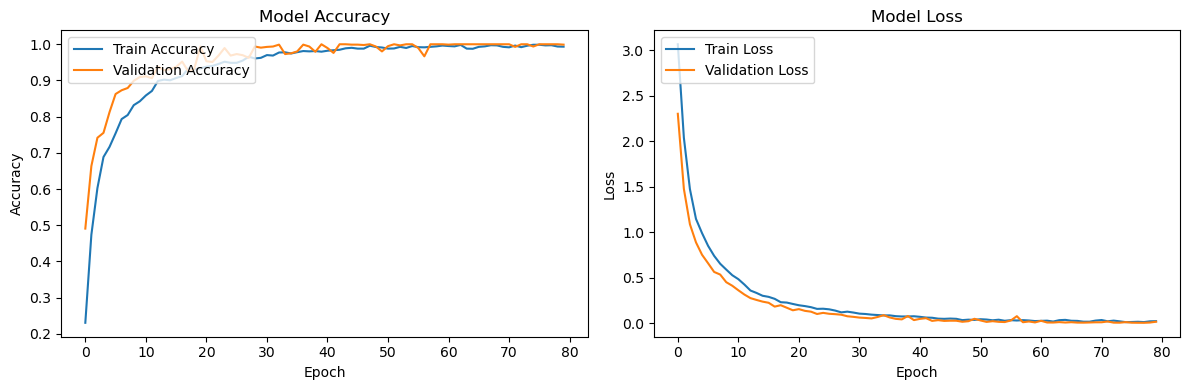

In [10]:
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

# After training your model, call the function:
plot_training_history(history)

In [11]:
model.save('best_model.h5')

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


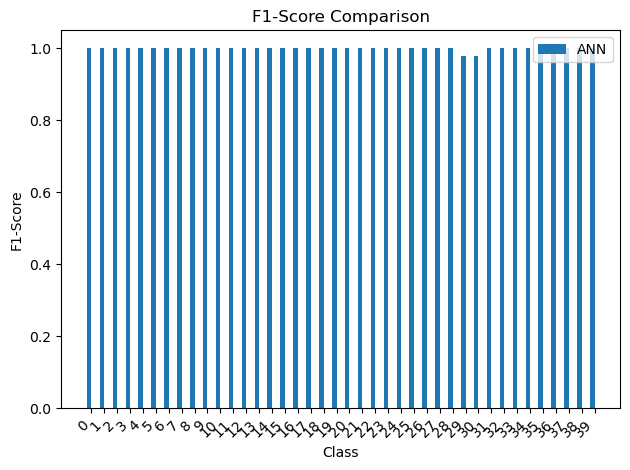

In [13]:
# 1. Get predictions
y_pred_ann = np.argmax(model.predict(X_test), axis=1)

# 2. Build reports
report_ann = classification_report(y_test, y_pred_ann, output_dict=True)

df_ann = pd.DataFrame(report_ann).transpose()

# 3. Plot F1-score comparison
classes = [c for c in df_ann.index if c not in ["accuracy","macro avg","weighted avg"]]
x = np.arange(len(classes)); width = 0.35

plt.figure()
plt.bar(x,             df_ann.loc[classes, "f1-score"], width, label="ANN")
plt.xticks(x + width/2, classes, rotation=45, ha="right")
plt.xlabel("Class"); plt.ylabel("F1-Score")
plt.title("F1-Score Comparison")
plt.legend(); plt.tight_layout()
plt.show()